In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import pandas as pd
from src.misc_utils import *
from src.model_utils import *
from src.sequence_utils import *
from src.portfolio import *
from src.data import update
from yahooquery import Ticker
import os
from datetime import datetime,timedelta
import sqlite3

In [3]:
DATA_DIR="/home/notebooks/"
MODELS_DIR="/home/notebooks/"
DB_PATH="/home/stock_db"
HORIZON=7
PRICE_COLUMN="Close"
LOOKBACK=365*2 ##two years 
HISTORY=14
FORECAST_STEPS=1
FUTURE=0
TARGET=f"log_return_{HORIZON}"

In [4]:
conn=create_connection(DB_PATH)
today=datetime.today().strftime("%Y-%m-%d")
yesterday=(datetime.today()-timedelta(days=1)).strftime("%Y-%m-%d")
initial_date=(datetime.today()-timedelta(days=LOOKBACK)).strftime("%Y-%m-%d")
logging.info(f"Today: {today}")
logging.info(f"Yesterday: {yesterday}")
logging.info(f"Data Start Date: {initial_date}")
update(conn=conn) ### UPDATE Price Data
data=pd.read_sql(f"SELECT * FROM stock_price WHERE date>='{initial_date} 00:00:00'",con=conn)
data=data.groupby(["ticker","date"],as_index=False).mean()
profile=pd.read_sql(f"SELECT ticker,industry FROM profile",con=conn)
data=data.merge(profile,on="ticker",how="left")
data=data[["date","ticker","industry","Close"]]
data["date"]=pd.to_datetime(data["date"])
start_date=data.date.min()
end_date=data.date.max()

calendar=build_calendar(start_date=start_date,end_date=end_date,forecast_horizon=5*HORIZON,forecast_steps=FORECAST_STEPS)
calendar=get_train_val_test(calendar=calendar,end_date=end_date,horizon=HORIZON,test_ratio=.0,val_ratio=.0)
grid=build_grid(data,calendar)
data=data.merge(grid,on=["date","ticker"],how="right")
return_cols=[]
if HORIZON>1:
    for i in range(1,HORIZON+1):
        data=shift(data,lag=i,column=PRICE_COLUMN)
        return_cols.append(f"log_return_{i}_shift_-{i}")
        data[f"log_return_{i}"]=np.log(data[f"{PRICE_COLUMN}_shift_{i}"]/data[PRICE_COLUMN])
        data=shift(data,lag=-i,column=f"log_return_{i}")
norm=Normaliser()
norm.load(f"{MODELS_DIR}/normaliser")
data=norm.normalise(data)
num_features=["Close_scaled"]+return_cols
initial_available_date=data[~data[TARGET].isnull()].date.min()

enc=Encoder()
enc.load(f"{MODELS_DIR}/encoder")
features=enc.get_encoded_features()
features=features+num_features
data=enc.apply(data)
inference_date=data[(data.weekend==0)&(data.holiday=="no_holiday")&(data.date>data[~data[TARGET].isnull()][f"lag_date_Close_{HORIZON}"].max())].date.min()
sequencer=TimeseriesSquencer(
    features=features,
    target=TARGET,
    history=HISTORY,
    future=FUTURE,
    steps=FORECAST_STEPS,
    id_column="ticker",
    time_column="date",
    data_end_date=inference_date.strftime("%Y-%m-%d"),
    include_target_feature=False,
    extra_id_columns=[])
train_dict=sequencer.sequence_timeseries(data[data.train==1].dropna())
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_root_mean_squared_error',
                                            patience=10,
                                              restore_best_weights=True,
                                            mode='min') 
def same_sign(y_true,y_pred):
    return tf.reduce_sum(tf.abs(tf.cast(tf.sign(y_true),dtype=tf.float64)+tf.cast(tf.sign(y_pred),dtype=tf.float64))/2)/tf.reduce_sum(tf.abs(tf.cast(tf.sign(y_true),dtype=tf.float64)))    


model_path=get_latest_model_path(models_dir=MODELS_DIR,prefix="model-")            
model = tf.keras.models.load_model(model_path, custom_objects={'same_sign':same_sign})

In [ ]:
#start_date=inference_date-pd.Timedelta(days=100)

In [5]:
tmp=data[(data.working_day==1)&(data.date>=start_date)].copy()

In [6]:
data_dict=sequencer.sequence_timeseries(tmp)

In [7]:
result=get_predictions(model,tmp,data_dict,steps=[0])

2023-06-12 21:00:38.475907: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 531092352 exceeds 10% of free system memory.


2410/2410 [==============================] - 52s 21ms/step


In [8]:
rmse = lambda x,y:np.sqrt(np.mean((x-y)**2))

<AxesSubplot: xlabel='date'>

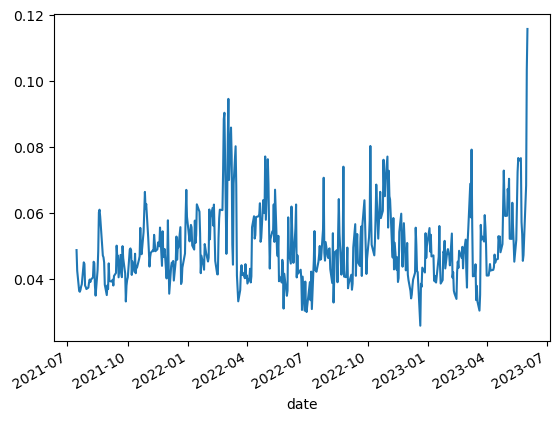

In [9]:
result.groupby("date").apply(lambda x: rmse(x[TARGET],x["pred_step_0"])).sort_values().plot()

In [10]:
rmse_quality=result.dropna().groupby("ticker")[[TARGET,"pred_step_0"]].apply(lambda x: rmse(x.tail(30)[TARGET],x.tail(30)["pred_step_0"])).sort_values()

<AxesSubplot: xlabel='ticker'>

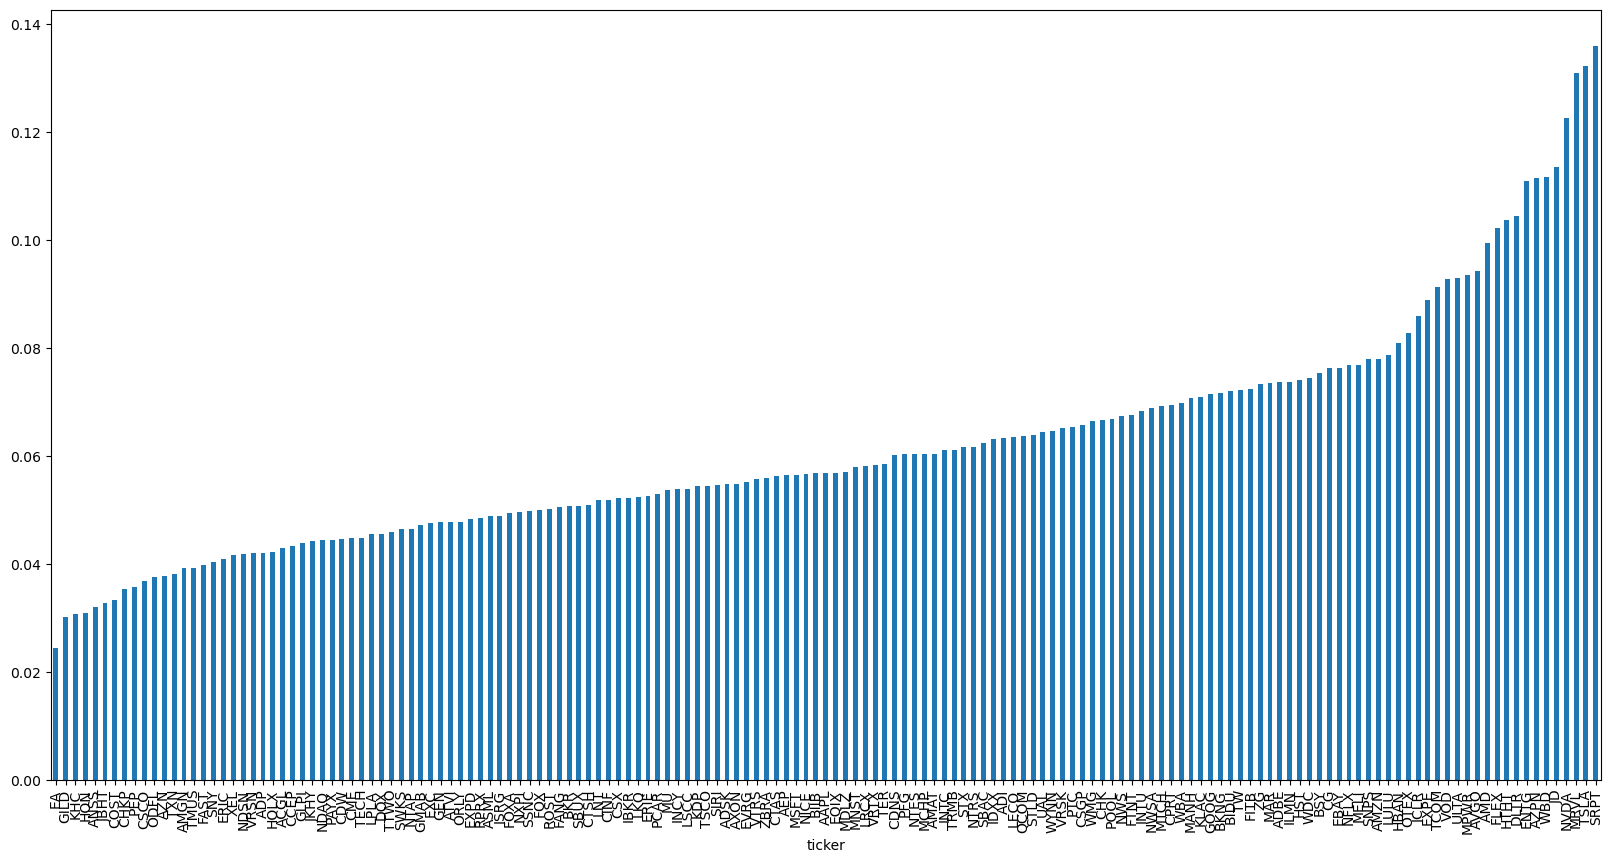

In [11]:
rmse_quality.plot.bar(figsize=(20,10))

In [12]:
result["zero"]=0

<AxesSubplot: >

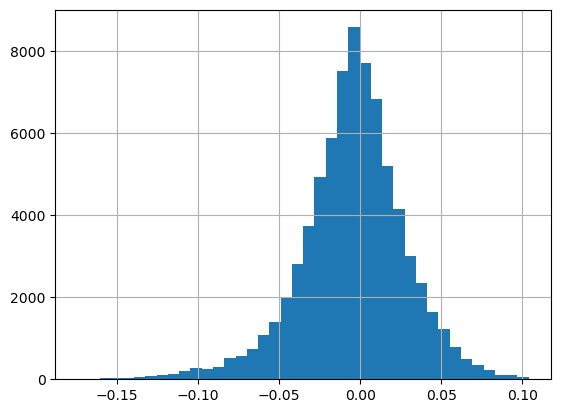

In [13]:
result.pred_step_0.hist(bins=40)

<AxesSubplot: >

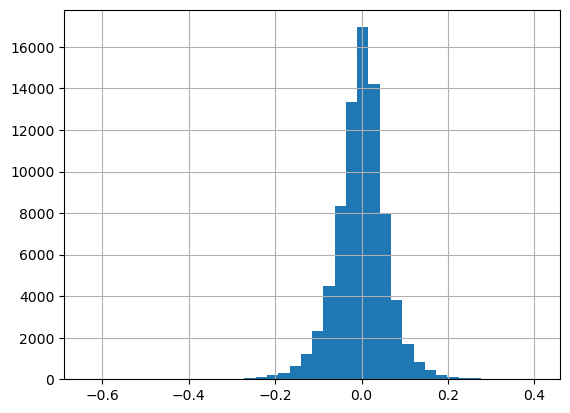

In [14]:
result.log_return_7.hist(bins=40)

In [15]:
result[(result.date==inference_date)&(result.pred_step_0>0)]

,date,ticker,industry,Close,holiday,dow,weekend,woy,working_day,i,...,woy_49,woy_50,woy_51,woy_52,dow_1,dow_2,dow_3,dow_4,pred_step_0,zero
1026,2023-06-13,ACGL,NaN,NaN,no_holiday,1,0,24,1,501.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.004236,0
1551,2023-06-13,ADBE,NaN,NaN,no_holiday,1,0,24,1,501.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.018213,0
2601,2023-06-13,ADP,NaN,NaN,no_holiday,1,0,24,1,501.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.013440,0
3126,2023-06-13,ADSK,NaN,NaN,no_holiday,1,0,24,1,501.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.033925,0
3651,2023-06-13,AEP,NaN,NaN,no_holiday,1,0,24,1,501.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.020967,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80301,2023-06-13,WDC,NaN,NaN,no_holiday,1,0,24,1,501.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.009783,0
80826,2023-06-13,WMG,NaN,NaN,no_holiday,1,0,24,1,501.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.015950,0
81876,2023-06-13,XEL,NaN,NaN,no_holiday,1,0,24,1,501.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.014947,0
82401,2023-06-13,ZBRA,NaN,NaN,no_holiday,1,0,24,1,501.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.015589,0


<AxesSubplot: xlabel='date'>

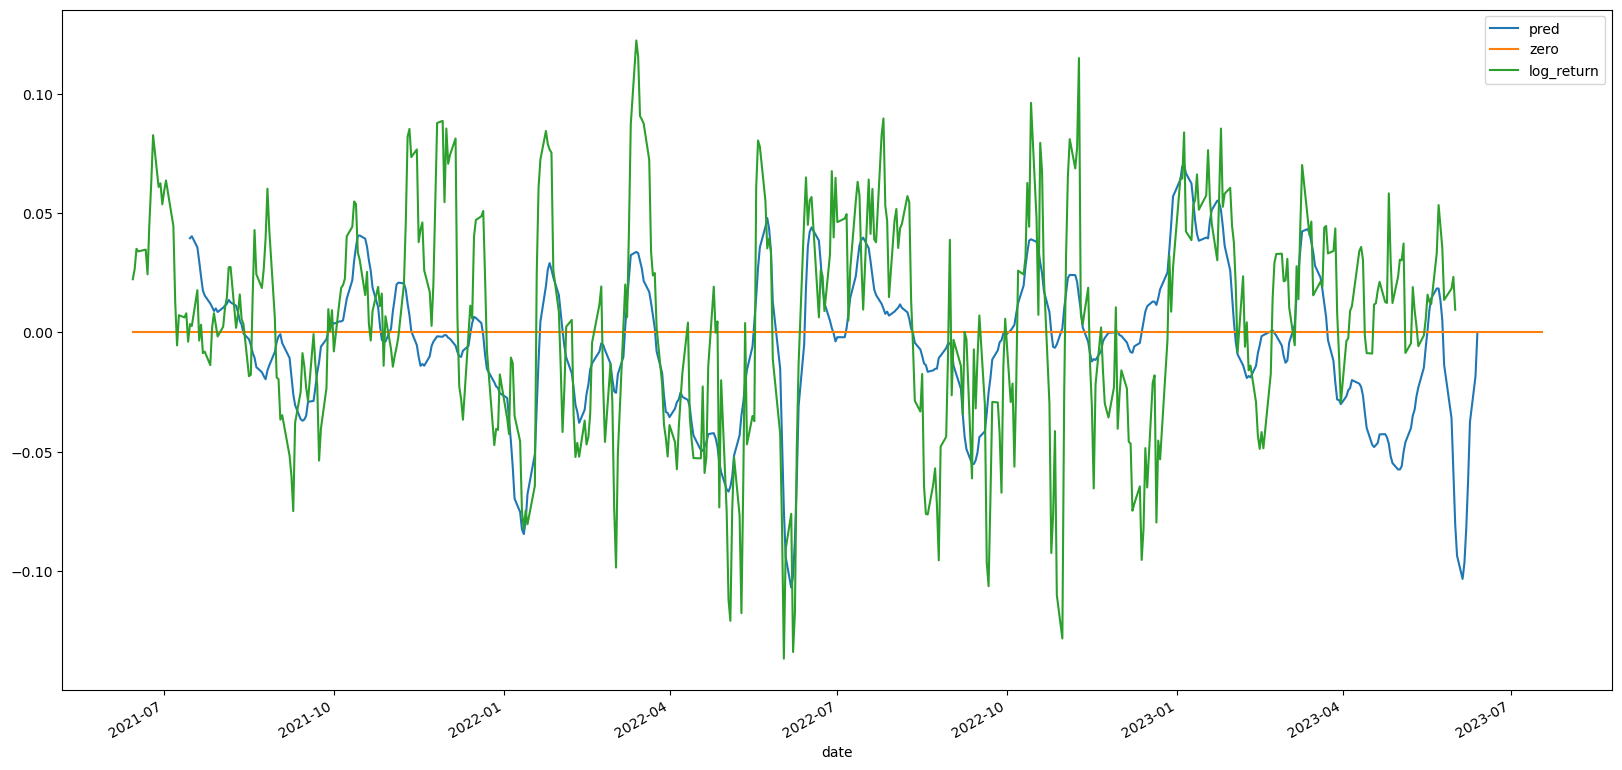

In [16]:
result[result.ticker=="AAPL"].groupby("date").agg(pred=("pred_step_0","mean"),zero=("zero","mean"),log_return=(TARGET,"mean")).plot(figsize=(20,10))

In [17]:
RISK_LEVEL=0.01

In [18]:
expected_price="Close_shift_-1"

In [19]:
## PREDICTED CLOSE FOR NEXT TRADING DAY
if not expected_price in result.columns:
    result=shift(result,lag=-1,column="Close")

In [20]:
import datetime
today=datetime.datetime.today()

In [21]:
#result=result[result.date<=today]

In [22]:
tickers=result.ticker.unique()

In [23]:
MIN_BUDGET=0
MAX_BUDGET=1000
CNT_EXPERIMENTS=10

----
## SIMULATION
----

<AxesSubplot: xlabel='date'>

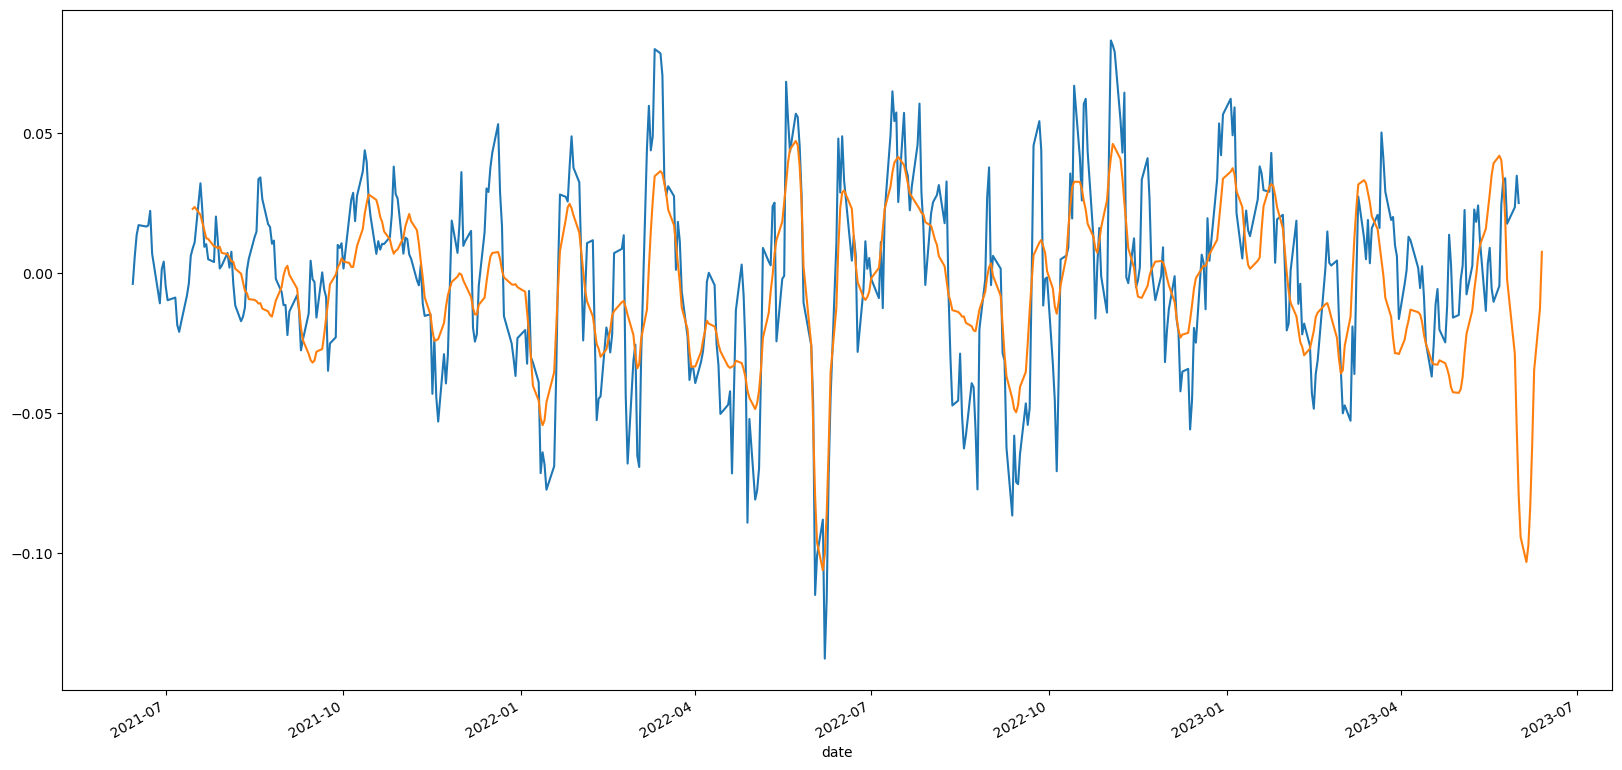

In [25]:
result.groupby("date").log_return_7.mean().plot(figsize=(20,10))
result.groupby("date").pred_step_0.mean().plot()

In [26]:
expected_price_col="Close_shift_-1"
expected_log_return_col="pred_step_0"
actual_price_col="Close"

In [27]:
CNT_EXPERIMENTS=50

In [28]:
from scipy.stats import norm as dist

In [38]:
dates=[]
actual_investments=[]
expected_investments=[]
values_at_risk=[]
predicted_returns=[]
actual_returns=[]
maturity_dates=[]
shares=[]
opt_results=[]
successful_opt=[]
for date in result[result.date<=inference_date].date.unique()[-CNT_EXPERIMENTS:]:
    opt_ticker,opt_shares,opt_success=maximise_returns(result=result,
                     date=date,
                     expected_price_col=expected_price_col,
                     expected_log_return_col=expected_log_return_col,
                     log_return_col=TARGET,
                     log_return_horizon=HORIZON,
                     min_expected_log_return=-.001,
                     max_value_at_risk=10,
                     confidence_level=.99,
                     max_budget=1000,
                     min_budget=0,
                     diversity=.2,
                    )
    successful_opt.append(opt_success)
    shares_date=pd.DataFrame(zip(opt_ticker,np.round(opt_shares,5)),columns=["ticker","share"])
    shares_date["date"]=date
    opt_results.append(shares_date)
    date_results=result[(result.ticker.isin(opt_ticker))&(result.date==date)]
    expected_prices=date_results[expected_price_col].to_numpy()
    expected_investment=portfolio_expected_investment(shares=opt_shares,prices=expected_prices)
    prices=date_results[actual_price_col].to_numpy()
    actual_investment=portfolio_expected_investment(shares=opt_shares,prices=prices)
    expected_log_returns=date_results[expected_log_return_col].to_numpy()
    log_returns=date_results[TARGET].to_numpy()
    
    z = dist.ppf(1 - .95)
    hist=get_historical_returns(data=result[result.ticker.isin(opt_ticker)],date=date,log_return_col=TARGET)
    value_at_risk=var(hist=hist,shares=opt_shares,prices=expected_prices,z=z)
    expected_return=portfolio_expected_return(shares=opt_shares,prices=expected_prices,log_returns=expected_log_returns)
    actual_return=portfolio_expected_return(shares=opt_shares,prices=prices,log_returns=log_returns)

    dates.append(date)
    actual_investments.append(actual_investment)
    expected_investments.append(expected_investment)
    values_at_risk.append(value_at_risk)
    predicted_returns.append(expected_return)
    actual_returns.append(actual_return)
    maturity_dates.append(result[result.date==date]["lag_date_Close_7"].unique()[0])

['ADP' 'AEP' 'AMGN' 'BIIB' 'BKR' 'CHK' 'COST' 'EA' 'EVRG' 'EXC' 'EXPE'
 'GILD' 'GMAB' 'HST' 'INCY' 'KDP' 'LNT' 'LPLA' 'LULU' 'PAYX' 'ROST' 'RPRX'
 'SNY' 'STLD' 'TECH' 'TTWO' 'TW' 'VOD' 'VRSK' 'VTRS' 'WBA' 'XEL']


/opt/conda/lib/python3.9/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.030599611578147657
       x: [ 1.642e-10  2.727e-08 ...  7.477e-09  1.175e-09]
     nit: 37
     jac: [ 7.253e-02  1.566e-02 ...  1.156e-02  1.215e-02]
    nfev: 1192
    njev: 36
['ADP' 'AEP' 'AMGN' 'BIIB' 'BKR' 'CHK' 'COST' 'CSX' 'EA' 'EVRG' 'EXC'
 'EXPE' 'GMAB' 'HST' 'INCY' 'KDP' 'LNT' 'LPLA' 'LULU' 'ORLY' 'PAYX' 'POOL'
 'ROST' 'RPRX' 'STLD' 'TECH' 'TTWO' 'TW' 'VOD' 'VRSK' 'VTRS' 'WBA' 'XEL']


/opt/conda/lib/python3.9/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.026978096054495283
       x: [ 1.000e-10  1.000e-10 ...  1.000e-10  1.000e-10]
     nit: 37
     jac: [ 5.860e-02  1.137e-02 ...  7.417e-03  9.037e-03]
    nfev: 1262
    njev: 37
['ADP' 'AEP' 'AMGN' 'BIIB' 'BKR' 'CHK' 'COST' 'CSX' 'DLTR' 'EA' 'EVRG'
 'EXC' 'EXPE' 'GMAB' 'HST' 'INCY' 'KDP' 'LNT' 'LPLA' 'LULU' 'PAYX' 'POOL'
 'RPRX' 'STLD' 'TECH' 'TTWO' 'TW' 'VOD' 'VRSK' 'VTRS' 'WBA' 'XEL']


/opt/conda/lib/python3.9/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.02268541779140128
       x: [ 1.000e-10  1.000e-10 ...  1.000e-10  1.000e-10]
     nit: 44
     jac: [ 5.204e-02  8.208e-03 ...  4.444e-03  6.909e-03]
    nfev: 1421
    njev: 43
['ADP' 'AEP' 'AMGN' 'BIIB' 'CHK' 'COST' 'CSX' 'CTSH' 'DLTR' 'EA' 'EVRG'
 'EXC' 'EXPE' 'FAST' 'HST' 'INCY' 'JBHT' 'JKHY' 'KDP' 'LNT' 'LPLA' 'LULU'
 'NTAP' 'NTRS' 'PAYX' 'POOL' 'RPRX' 'SBAC' 'STLD' 'STX' 'TECH' 'TTWO'
 'VOD' 'VRSK' 'VTRS' 'WBA' 'WDC' 'XEL']


/opt/conda/lib/python3.9/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.026583727100985256
       x: [ 1.000e-10  1.000e-10 ...  1.000e-10  1.000e-10]
     nit: 42
     jac: [ 9.233e-02  1.810e-02 ...  1.419e-02  1.525e-02]
    nfev: 1600
    njev: 41
['AEP' 'BIIB' 'CHK' 'COST' 'CSX' 'CTSH' 'EA' 'EVRG' 'EXC' 'EXPE' 'HON'
 'HST' 'INCY' 'INTC' 'JBHT' 'JKHY' 'KDP' 'LNT' 'LULU' 'MRVL' 'NTAP' 'PAYX'
 'POOL' 'QCOM' 'RPRX' 'SBAC' 'STLD' 'STX' 'TECH' 'TTWO' 'VOD' 'VRSK'
 'VTRS' 'WBA' 'WDC' 'XEL']


/opt/conda/lib/python3.9/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.02724679984784366
       x: [ 1.000e-10  1.000e-10 ...  1.000e-10  1.000e-10]
     nit: 33
     jac: [ 2.315e-02  1.369e-01 ...  1.171e-02  1.934e-02]
    nfev: 1225
    njev: 33
['AEP' 'COST' 'CSX' 'CTSH' 'ENTG' 'EVRG' 'EXC' 'EXPD' 'EXPE' 'HON' 'HST'
 'INTC' 'JBHT' 'JKHY' 'KDP' 'LNT' 'MRVL' 'MU' 'NTAP' 'POOL' 'QCOM' 'RPRX'
 'SBAC' 'STLD' 'STX' 'SWKS' 'TECH' 'TTWO' 'VOD' 'VRSK' 'VTRS' 'WBA' 'WDC'
 'XEL']


/opt/conda/lib/python3.9/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.028619793421513183
       x: [ 1.000e-10  1.000e-10 ...  1.000e-10  1.000e-10]
     nit: 35
     jac: [ 3.010e-02  2.092e-01 ...  1.130e-02  2.498e-02]
    nfev: 1192
    njev: 34
['AEP' 'COST' 'CSX' 'CTSH' 'ENTG' 'EVRG' 'EXC' 'EXPD' 'EXPE' 'FITB' 'HON'
 'HST' 'INTC' 'JBHT' 'JKHY' 'KDP' 'LNT' 'MRVL' 'MU' 'NTAP' 'POOL' 'QCOM'
 'STLD' 'STX' 'SWKS' 'TECH' 'VOD' 'VRSK' 'VTRS' 'WBA' 'WDC' 'XEL']


/opt/conda/lib/python3.9/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.029335608152902364
       x: [ 1.000e-10  1.000e-10 ...  1.000e-10  1.000e-10]
     nit: 37
     jac: [ 4.573e-02  2.836e-01 ...  1.364e-02  3.786e-02]
    nfev: 1190
    njev: 36
['CSX' 'ENTG' 'EVRG' 'EXPD' 'EXPE' 'FITB' 'HON' 'HST' 'INTC' 'JBHT' 'JKHY'
 'KDP' 'LNT' 'MRVL' 'MU' 'NTAP' 'POOL' 'QCOM' 'STLD' 'STX' 'SWKS' 'TECH'
 'VOD' 'VTRS' 'WBA' 'WDC']


/opt/conda/lib/python3.9/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/opt/conda/lib/python3.9/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.02645138492791176
       x: [ 1.000e-10  1.000e-10 ...  1.000e-10  1.000e-10]
     nit: 34
     jac: [ 6.419e-03  2.675e-02 ...  1.200e-02  1.471e-02]
    nfev: 894
    njev: 33
['CSX' 'ENTG' 'EXPE' 'FITB' 'HON' 'HST' 'INTC' 'JBHT' 'KDP' 'LNT' 'MRVL'
 'MU' 'NTAP' 'QCOM' 'STLD' 'STX' 'SWKS' 'VOD' 'VTRS' 'WBA' 'WDC']
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.023165545007313354
       x: [ 1.000e-10  1.000e-10 ...  1.000e-10  1.000e-10]
     nit: 35
     jac: [ 8.565e-03  1.839e-02 ...  1.205e-02  1.554e-02]
    nfev: 751
    njev: 34
['ENTG' 'EXPE' 'INTC' 'JBHT' 'KDP' 'MRVL' 'MU' 'QCOM' 'STLD' 'VOD']
['ENTG' 'EXPE' 'INTC' 'KDP' 'MRVL' 'MU' 'QCOM' 'STLD']


/home/notebooks/src/portfolio.py:119: RuntimeWarning: invalid value encountered in divide
  risk = lambda hist,shares,prices: np.sqrt(np.cov(hist.transpose()).dot(prices*shares/(np.sum(prices*shares))).dot(prices*shares/(np.sum(prices*shares))))
/home/notebooks/src/portfolio.py:118: RuntimeWarning: invalid value encountered in divide
  portfolio_expected_return=lambda shares,prices,log_returns: np.log(np.sum(prices*shares/(np.sum(prices*shares))*np.exp(log_returns)))
/home/notebooks/src/portfolio.py:119: RuntimeWarning: invalid value encountered in divide
  risk = lambda hist,shares,prices: np.sqrt(np.cov(hist.transpose()).dot(prices*shares/(np.sum(prices*shares))).dot(prices*shares/(np.sum(prices*shares))))
/home/notebooks/src/portfolio.py:118: RuntimeWarning: invalid value encountered in divide
  portfolio_expected_return=lambda shares,prices,log_returns: np.log(np.sum(prices*shares/(np.sum(prices*shares))*np.exp(log_returns)))
/home/notebooks/src/portfolio.py:119: RuntimeWarning: in

['INTC' 'KDP' 'MRVL' 'MU' 'QCOM']
['INTC' 'MRVL' 'MU' 'QCOM']
['INTC' 'MRVL' 'MU' 'QCOM' 'SWKS']
['AMD' 'INTC' 'MRVL' 'MU' 'NXPI' 'QCOM' 'SWKS']
['AMD' 'INTC' 'MRVL' 'MU' 'NXPI' 'QCOM' 'SWKS']
['INTC' 'MRVL' 'MU' 'QCOM' 'SWKS']
['MRVL' 'MU' 'QCOM']
[]
[]
[]
[]
['AEP' 'EVRG' 'EXC' 'LNT' 'WBA']
['AEP' 'CG' 'ENTG' 'EVRG' 'EXC' 'GEN' 'LNT' 'MRVL' 'MTCH' 'NTRS' 'VOD'
 'WBA' 'XEL']
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.01188224119190694
       x: [ 1.000e-10  1.000e-10 ...  2.278e+00  1.000e-10]
     nit: 35
     jac: [ 9.051e-03  2.858e-03 ...  0.000e+00  9.242e-03]
    nfev: 490
    njev: 35
['ADBE' 'AEP' 'BKR' 'CG' 'CHK' 'CHKP' 'ENTG' 'EVRG' 'EXC' 'GEN' 'INTC'
 'KDP' 'LNT' 'MRVL' 'MTCH' 'MU' 'NTRS' 'POOL' 'QCOM' 'RPRX' 'STLD' 'SWKS'
 'TECH' 'TTWO' 'VOD' 'VRSK' 'VTRS' 'WBA' 'XEL' 'ZG']


/opt/conda/lib/python3.9/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.019718129708272768
       x: [ 7.768e-10  1.022e-10 ...  2.086e-10  1.016e-10]
     nit: 36
     jac: [ 2.697e-02  1.086e-02 ...  1.047e-02  7.192e-03]
    nfev: 1120
    njev: 36
['ADBE' 'ADSK' 'AEP' 'AMAT' 'AMD' 'AMGN' 'BIIB' 'BKR' 'BSY' 'CG' 'CHK'
 'CHKP' 'EA' 'ENTG' 'ERIC' 'EVRG' 'EXC' 'FITB' 'FTNT' 'GEN' 'GOOG' 'HBAN'
 'HST' 'ICLR' 'ILMN' 'INCY' 'INTC' 'INTU' 'KDP' 'LNT' 'LRCX' 'MRVL' 'MSFT'
 'MTCH' 'MU' 'NICE' 'NTAP' 'NTRS' 'NWS' 'NWSA' 'NXPI' 'PFG' 'POOL' 'QCOM'
 'RPRX' 'SBAC' 'SIRI' 'SSNC' 'STLD' 'STX' 'SWKS' 'TECH' 'TTWO' 'TW' 'UAL'
 'VOD' 'VRSK' 'VRSN' 'VTRS' 'WBA' 'WDC' 'XEL' 'ZBRA' 'ZG']


/opt/conda/lib/python3.9/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.029615957898090642
       x: [ 1.000e-10  1.000e-10 ...  1.000e-10  1.000e-10]
     nit: 48
     jac: [ 5.349e-02  1.012e-01 ...  2.144e-01  1.735e-02]
    nfev: 3123
    njev: 48
['ADBE' 'ADSK' 'AEP' 'AMAT' 'AMD' 'AMGN' 'ANSS' 'ASML' 'ATVI' 'AZPN'
 'BIDU' 'BIIB' 'BKR' 'BSY' 'CG' 'CHK' 'CHKP' 'CME' 'CSCO' 'EA' 'ENTG'
 'ERIC' 'EVRG' 'EXC' 'FANG' 'FAST' 'FITB' 'FOX' 'FOXA' 'FTNT' 'GEN' 'GMAB'
 'GOOG' 'HBAN' 'HST' 'ICLR' 'IDXX' 'ILMN' 'INCY' 'INTC' 'INTU' 'ISRG'
 'KDP' 'KLAC' 'LNT' 'LPLA' 'LRCX' 'MANH' 'MRVL' 'MSFT' 'MTCH' 'MU' 'NDAQ'
 'NDSN' 'NFLX' 'NICE' 'NTAP' 'NTES' 'NTRS' 'NWS' 'NWSA' 'NXPI' 'OTEX'
 'PFG' 'POOL' 'PTC' 'QCOM' 'RPRX' 'SBAC' 'SIRI' 'SSNC' 'STLD' 'STX' 'SWKS'
 'TECH' 'TTWO' 'TW' 'UAL' 'VOD' 'VRSK' 'VRSN' 'VTRS' 'WBA' 'WBD' 'WDC'
 'WMG' 'XEL' 'ZBRA' 'ZG']


/opt/conda/lib/python3.9/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.03843289655459326
       x: [ 1.000e-10  1.000e-10 ...  1.000e-10  1.000e-10]
     nit: 57
     jac: [ 4.338e-02  5.285e-02 ...  1.690e-01  1.220e-02]
    nfev: 5045
    njev: 56
['ADBE' 'ADP' 'ADSK' 'AEP' 'AMAT' 'AMD' 'AMGN' 'AMZN' 'ANSS' 'ASML' 'ATVI'
 'AZPN' 'BIDU' 'BIIB' 'BKR' 'BSY' 'CDW' 'CG' 'CHK' 'CHKP' 'CME' 'CSCO'
 'CTSH' 'DOX' 'EA' 'EBAY' 'ENTG' 'EQIX' 'ERIC' 'EVRG' 'EXC' 'EXPE' 'FANG'
 'FAST' 'FITB' 'FOX' 'FOXA' 'FTNT' 'GEN' 'GMAB' 'GOOG' 'HBAN' 'HST' 'HTHT'
 'IBKR' 'ICLR' 'IDXX' 'ILMN' 'INCY' 'INTC' 'INTU' 'ISRG' 'JD' 'JKHY' 'KDP'
 'KLAC' 'LNT' 'LPLA' 'LRCX' 'MANH' 'MELI' 'MRVL' 'MSFT' 'MTCH' 'MU' 'NDAQ'
 'NDSN' 'NFLX' 'NICE' 'NTAP' 'NTES' 'NTRS' 'NWS' 'NWSA' 'NXPI' 'OTEX'
 'PAYX' 'PFG' 'POOL' 'PTC' 'QCOM' 'RPRX' 'SBAC' 'SIRI' 'SRPT' 'SSNC'
 'STLD' 'STX' 'SWKS' 'TECH' 'TER' 'TTWO' 'TW' 'TXN' 'UAL' 'VOD' 'VRSK'
 'VRSN' 'VTRS' 'WBA' 'WBD' 'WDC' 'WMG' 'XEL' 'ZBRA' 'ZG']


/opt/conda/lib/python3.9/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.048519192030177336
       x: [ 1.000e-10  1.000e-10 ...  1.000e-10  1.000e-10]
     nit: 54
     jac: [ 6.836e-02  2.093e-01 ...  2.089e-01  1.311e-02]
    nfev: 5675
    njev: 53
['ADBE' 'ADP' 'ADSK' 'AEP' 'AMAT' 'AMD' 'AMGN' 'AMZN' 'ANSS' 'ASML' 'ATVI'
 'AZPN' 'BIDU' 'BIIB' 'BKR' 'BSY' 'CDNS' 'CDW' 'CG' 'CHK' 'CHKP' 'CME'
 'CSCO' 'CSGP' 'CTSH' 'DOX' 'EA' 'EBAY' 'ENTG' 'EQIX' 'ERIC' 'EVRG' 'EXC'
 'EXPE' 'FANG' 'FAST' 'FITB' 'FOX' 'FOXA' 'FTNT' 'GEN' 'GLPI' 'GMAB'
 'GOOG' 'HBAN' 'HON' 'HST' 'HTHT' 'IBKR' 'ICLR' 'IDXX' 'ILMN' 'INCY'
 'INTC' 'INTU' 'ISRG' 'JD' 'JKHY' 'KDP' 'KLAC' 'LNT' 'LPLA' 'LRCX' 'MANH'
 'MCHP' 'MELI' 'MPWR' 'MRVL' 'MSFT' 'MTCH' 'MU' 'NDAQ' 'NDSN' 'NFLX'
 'NICE' 'NTAP' 'NTES' 'NTRS' 'NWS' 'NWSA' 'NXPI' 'OTEX' 'PAYX' 'PFG'
 'POOL' 'PTC' 'QCOM' 'RPRX' 'SBAC' 'SIRI' 'SNPS' 'SRPT' 'SSNC' 'STLD'
 'STX' 'SWKS' 'TECH' 'TER' 'TTWO' 'TW' 'TXN' 'UAL' 'VOD' 'VRSK' 'VRSN'
 'VTRS' 'WBA' 'WBD' 'W

/opt/conda/lib/python3.9/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.055136733300934895
       x: [ 1.000e-10  1.000e-10 ...  1.000e-10  1.000e-10]
     nit: 56
     jac: [ 9.037e-02  1.839e-01 ...  1.892e-01  1.191e-02]
    nfev: 6275
    njev: 55
['ADBE' 'ADP' 'ADSK' 'AEP' 'AMAT' 'AMD' 'AMGN' 'AMZN' 'ANSS' 'ASML' 'ATVI'
 'AZPN' 'BIDU' 'BIIB' 'BKR' 'BSY' 'CDNS' 'CDW' 'CG' 'CHK' 'CHKP' 'CINF'
 'CME' 'COST' 'CSCO' 'CSGP' 'CSX' 'CTSH' 'DOX' 'EA' 'EBAY' 'ENTG' 'EQIX'
 'ERIC' 'ERIE' 'EVRG' 'EXC' 'EXPE' 'FANG' 'FAST' 'FITB' 'FOX' 'FOXA'
 'FTNT' 'GEN' 'GLPI' 'GMAB' 'GOOG' 'HBAN' 'HON' 'HST' 'HTHT' 'IBKR' 'ICLR'
 'IDXX' 'ILMN' 'INCY' 'INTC' 'INTU' 'ISRG' 'JD' 'JKHY' 'KDP' 'KLAC' 'LECO'
 'LNT' 'LPLA' 'LRCX' 'MANH' 'MAR' 'MCHP' 'MELI' 'MPWR' 'MRVL' 'MSFT'
 'MTCH' 'MU' 'NDAQ' 'NDSN' 'NFLX' 'NICE' 'NTAP' 'NTES' 'NTRS' 'NVDA' 'NWS'
 'NWSA' 'NXPI' 'ODFL' 'OTEX' 'PAYX' 'PFG' 'POOL' 'PTC' 'QCOM' 'RPRX'
 'SBAC' 'SIRI' 'SNPS' 'SRPT' 'SSNC' 'STLD' 'STX' 'SWKS' 'TECH' 'TER'
 'TMUS' 'TRM

/opt/conda/lib/python3.9/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.06275275050654971
       x: [ 1.000e-10  1.000e-10 ...  1.000e-10  1.000e-10]
     nit: 51
     jac: [ 1.256e-01  1.820e-01 ...  2.000e-01  1.275e-02]
    nfev: 6255
    njev: 50
['ADBE' 'ADI' 'ADP' 'ADSK' 'AEP' 'AMAT' 'AMD' 'AMGN' 'AMZN' 'ANSS' 'ASML'
 'ATVI' 'AVGO' 'AZPN' 'BIDU' 'BIIB' 'BKR' 'BSY' 'CDNS' 'CDW' 'CG' 'CHK'
 'CHKP' 'CINF' 'CME' 'COST' 'CSCO' 'CSGP' 'CSX' 'CTSH' 'DOX' 'EA' 'EBAY'
 'ENTG' 'EQIX' 'ERIC' 'ERIE' 'EVRG' 'EXC' 'EXPE' 'FANG' 'FAST' 'FITB'
 'FLEX' 'FOX' 'FOXA' 'FTNT' 'GEN' 'GILD' 'GLPI' 'GMAB' 'GOOG' 'HBAN' 'HON'
 'HST' 'HTHT' 'IBKR' 'ICLR' 'IDXX' 'ILMN' 'INCY' 'INTC' 'INTU' 'ISRG' 'JD'
 'JKHY' 'KDP' 'KLAC' 'LECO' 'LKQ' 'LNT' 'LPLA' 'LRCX' 'LSCC' 'MANH' 'MAR'
 'MCHP' 'MELI' 'MPWR' 'MRVL' 'MSFT' 'MTCH' 'MU' 'NDAQ' 'NDSN' 'NFLX'
 'NICE' 'NTAP' 'NTES' 'NTRS' 'NVDA' 'NWS' 'NWSA' 'NXPI' 'ODFL' 'OTEX'
 'PAYX' 'PFG' 'POOL' 'PTC' 'QCOM' 'RPRX' 'SBAC' 'SBUX' 'SIRI' 'SNPS'
 'SRPT' 'SSNC

/opt/conda/lib/python3.9/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.06990766069732501
       x: [ 1.000e-10  1.000e-10 ...  1.000e-10  1.000e-10]
     nit: 51
     jac: [ 1.633e-01  2.193e-01 ...  2.100e-01  1.361e-02]
    nfev: 6754
    njev: 50
['AAPL' 'ADBE' 'ADI' 'ADP' 'ADSK' 'AEP' 'AMAT' 'AMD' 'AMGN' 'AMZN' 'ANSS'
 'ASML' 'ATVI' 'AVGO' 'AZPN' 'BIDU' 'BIIB' 'BKNG' 'BKR' 'BSY' 'CDNS' 'CDW'
 'CG' 'CHK' 'CHKP' 'CINF' 'CME' 'COST' 'CSCO' 'CSGP' 'CSX' 'CTSH' 'DLTR'
 'DOX' 'EA' 'EBAY' 'ENTG' 'EQIX' 'ERIC' 'ERIE' 'EVRG' 'EXC' 'EXPE' 'FANG'
 'FAST' 'FITB' 'FLEX' 'FOX' 'FOXA' 'FTNT' 'GEN' 'GILD' 'GLPI' 'GMAB'
 'GOOG' 'HBAN' 'HOLX' 'HON' 'HST' 'HTHT' 'IBKR' 'ICLR' 'IDXX' 'ILMN'
 'INCY' 'INTC' 'INTU' 'ISRG' 'JBHT' 'JD' 'JKHY' 'KDP' 'KLAC' 'LECO' 'LKQ'
 'LNT' 'LPLA' 'LRCX' 'LSCC' 'LULU' 'MANH' 'MAR' 'MCHP' 'MELI' 'MPWR'
 'MRVL' 'MSFT' 'MTCH' 'MU' 'NDAQ' 'NDSN' 'NFLX' 'NICE' 'NTAP' 'NTES'
 'NTRS' 'NVDA' 'NWS' 'NWSA' 'NXPI' 'ODFL' 'ORLY' 'OTEX' 'PAYX' 'PCAR'
 'PFG' 'POOL' 'PTC

/opt/conda/lib/python3.9/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.07694065814186349
       x: [ 1.000e-10  1.000e-10 ...  1.000e-10  1.000e-10]
     nit: 50
     jac: [ 2.433e-01  1.955e-01 ...  2.141e-01  1.383e-02]
    nfev: 7158
    njev: 49
['AAPL' 'ADBE' 'ADI' 'ADP' 'ADSK' 'AEP' 'AMAT' 'AMD' 'AMGN' 'AMZN' 'ANSS'
 'ASML' 'ATVI' 'AVGO' 'AXON' 'AZPN' 'BIDU' 'BIIB' 'BKNG' 'BKR' 'BSY'
 'CDNS' 'CDW' 'CG' 'CHK' 'CHKP' 'CINF' 'CME' 'COST' 'CPRT' 'CSCO' 'CSGP'
 'CSX' 'CTAS' 'CTSH' 'DLTR' 'DOX' 'EA' 'EBAY' 'ENTG' 'EQIX' 'ERIC' 'ERIE'
 'EVRG' 'EXC' 'EXPD' 'EXPE' 'FANG' 'FAST' 'FITB' 'FLEX' 'FOX' 'FOXA'
 'FTNT' 'GEN' 'GILD' 'GLPI' 'GMAB' 'GOOG' 'HBAN' 'HOLX' 'HON' 'HST' 'HTHT'
 'IBKR' 'ICLR' 'IDXX' 'ILMN' 'INCY' 'INTC' 'INTU' 'ISRG' 'JBHT' 'JD'
 'JKHY' 'KDP' 'KLAC' 'LECO' 'LKQ' 'LNT' 'LPLA' 'LRCX' 'LSCC' 'LULU' 'MANH'
 'MAR' 'MCHP' 'MELI' 'MPWR' 'MRVL' 'MSFT' 'MTCH' 'MU' 'NDAQ' 'NDSN' 'NFLX'
 'NICE' 'NTAP' 'NTES' 'NTRS' 'NVDA' 'NWS' 'NWSA' 'NXPI' 'ODFL' 'ORLY'
 'OTEX' 'PA

/opt/conda/lib/python3.9/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.08443137005813335
       x: [ 1.000e-10  1.000e-10 ...  1.000e-10  1.000e-10]
     nit: 48
     jac: [ 2.415e-01  2.315e-01 ...  2.320e-01  1.334e-02]
    nfev: 7054
    njev: 47
['AAPL' 'ADBE' 'ADI' 'ADP' 'ADSK' 'AEP' 'AMAT' 'AMD' 'AMGN' 'AMZN' 'ANSS'
 'ASML' 'ATVI' 'AVGO' 'AXON' 'AZPN' 'BIDU' 'BIIB' 'BKNG' 'BKR' 'BSY'
 'CDNS' 'CDW' 'CG' 'CHK' 'CHKP' 'CINF' 'CME' 'COST' 'CPRT' 'CSCO' 'CSGP'
 'CSX' 'CTAS' 'CTSH' 'DLTR' 'DOX' 'EA' 'EBAY' 'ENTG' 'EQIX' 'ERIC' 'ERIE'
 'EVRG' 'EXC' 'EXPD' 'EXPE' 'FANG' 'FAST' 'FITB' 'FLEX' 'FOX' 'FOXA'
 'FTNT' 'GEN' 'GILD' 'GLPI' 'GMAB' 'GOOG' 'HBAN' 'HOLX' 'HON' 'HST' 'HTHT'
 'IBKR' 'ICLR' 'IDXX' 'ILMN' 'INCY' 'INTC' 'INTU' 'ISRG' 'JBHT' 'JD'
 'JKHY' 'KDP' 'KLAC' 'LECO' 'LKQ' 'LNT' 'LPLA' 'LRCX' 'LSCC' 'LULU' 'MANH'
 'MAR' 'MCHP' 'MELI' 'MPWR' 'MRVL' 'MSFT' 'MTCH' 'MU' 'NDAQ' 'NDSN' 'NFLX'
 'NICE' 'NTAP' 'NTES' 'NTRS' 'NVDA' 'NWS' 'NWSA' 'NXPI' 'ODFL' 'ORLY'
 'OTEX' 'PA

/opt/conda/lib/python3.9/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.09088839198617042
       x: [ 1.007e-10  1.007e-10 ...  1.007e-10  4.170e-09]
     nit: 45
     jac: [ 2.498e-01  2.704e-01 ...  2.600e-01  1.212e-02]
    nfev: 6603
    njev: 44
['AAPL' 'ADBE' 'ADI' 'ADP' 'ADSK' 'AEP' 'AMAT' 'AMD' 'AMGN' 'AMZN' 'ANSS'
 'ASML' 'ATVI' 'AVGO' 'AXON' 'AZPN' 'BIDU' 'BIIB' 'BKNG' 'BKR' 'BSY'
 'CDNS' 'CDW' 'CG' 'CHK' 'CHKP' 'CINF' 'CME' 'COST' 'CPRT' 'CSCO' 'CSGP'
 'CSX' 'CTAS' 'CTSH' 'DLTR' 'DOX' 'EA' 'EBAY' 'ENTG' 'EQIX' 'ERIC' 'ERIE'
 'EVRG' 'EXC' 'EXPD' 'EXPE' 'FANG' 'FAST' 'FITB' 'FLEX' 'FOX' 'FOXA'
 'FTNT' 'GEN' 'GILD' 'GLPI' 'GMAB' 'GOOG' 'HBAN' 'HOLX' 'HON' 'HST' 'HTHT'
 'IBKR' 'ICLR' 'IDXX' 'ILMN' 'INCY' 'INTC' 'INTU' 'ISRG' 'JBHT' 'JD'
 'JKHY' 'KDP' 'KHC' 'KLAC' 'LECO' 'LKQ' 'LNT' 'LPLA' 'LRCX' 'LSCC' 'LULU'
 'MANH' 'MAR' 'MCHP' 'MELI' 'MPWR' 'MRVL' 'MSFT' 'MTCH' 'MU' 'NDAQ' 'NDSN'
 'NFLX' 'NICE' 'NTAP' 'NTES' 'NTRS' 'NVDA' 'NWS' 'NWSA' 'NXPI' 'ODFL'
 'ORLY' 'OTE

/opt/conda/lib/python3.9/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.09665602514422768
       x: [ 1.067e-10  1.095e-10 ...  1.083e-10  1.571e-07]
     nit: 44
     jac: [ 2.552e-01  3.157e-01 ...  2.909e-01  1.050e-02]
    nfev: 6493
    njev: 43
['AAPL' 'ACGL' 'ADBE' 'ADI' 'ADP' 'ADSK' 'AEP' 'AMAT' 'AMD' 'AMGN' 'AMZN'
 'ANSS' 'ASML' 'ATVI' 'AVGO' 'AXON' 'AZPN' 'BIDU' 'BIIB' 'BKNG' 'BKR'
 'BSY' 'CDNS' 'CDW' 'CG' 'CHK' 'CHKP' 'CINF' 'CME' 'COST' 'CPRT' 'CSCO'
 'CSGP' 'CSX' 'CTAS' 'CTSH' 'DLTR' 'DOX' 'EA' 'EBAY' 'ENTG' 'EQIX' 'ERIC'
 'ERIE' 'EVRG' 'EXC' 'EXPD' 'EXPE' 'FANG' 'FAST' 'FITB' 'FLEX' 'FOX'
 'FOXA' 'FTNT' 'GEN' 'GILD' 'GLPI' 'GMAB' 'GOOG' 'HBAN' 'HOLX' 'HON' 'HST'
 'HTHT' 'IBKR' 'ICLR' 'IDXX' 'ILMN' 'INCY' 'INTC' 'INTU' 'ISRG' 'JBHT'
 'JD' 'JKHY' 'KDP' 'KHC' 'KLAC' 'LECO' 'LKQ' 'LNT' 'LPLA' 'LRCX' 'LSCC'
 'LULU' 'MANH' 'MAR' 'MCHP' 'MELI' 'MPWR' 'MRVL' 'MSFT' 'MTCH' 'MU' 'NDAQ'
 'NDSN' 'NFLX' 'NICE' 'NTAP' 'NTES' 'NTRS' 'NVDA' 'NWS' 'NWSA' 'NXPI'
 'ODFL' 'ORL

/opt/conda/lib/python3.9/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.09898807729411321
       x: [ 1.000e-10  1.000e-10 ...  1.000e-10  1.000e-10]
     nit: 45
     jac: [ 2.615e-01  1.327e-01 ...  3.215e-01  9.415e-03]
    nfev: 6736
    njev: 44
['AAPL' 'ACGL' 'ADBE' 'ADI' 'ADP' 'ADSK' 'AEP' 'AMAT' 'AMD' 'AMGN' 'AMZN'
 'ANSS' 'ASML' 'ATVI' 'AVGO' 'AXON' 'AZPN' 'BIDU' 'BIIB' 'BKNG' 'BKR'
 'BSY' 'CDNS' 'CDW' 'CG' 'CHK' 'CHKP' 'CINF' 'CME' 'COST' 'CSCO' 'CSGP'
 'CSX' 'CTAS' 'CTSH' 'DLTR' 'DOX' 'EA' 'EBAY' 'ENTG' 'EQIX' 'ERIC' 'ERIE'
 'EVRG' 'EXC' 'EXPD' 'EXPE' 'FANG' 'FAST' 'FITB' 'FLEX' 'FOX' 'FOXA'
 'FTNT' 'GEN' 'GILD' 'GLPI' 'GMAB' 'GOOG' 'HBAN' 'HOLX' 'HON' 'HST' 'HTHT'
 'IBKR' 'ICLR' 'IDXX' 'ILMN' 'INCY' 'INTC' 'INTU' 'ISRG' 'JBHT' 'JD'
 'JKHY' 'KDP' 'KHC' 'KLAC' 'LECO' 'LKQ' 'LNT' 'LPLA' 'LRCX' 'LSCC' 'LULU'
 'MANH' 'MAR' 'MCHP' 'MELI' 'MPWR' 'MRVL' 'MSFT' 'MTCH' 'MU' 'NDAQ' 'NDSN'
 'NFLX' 'NICE' 'NTAP' 'NTES' 'NTRS' 'NVDA' 'NWS' 'NWSA' 'NXPI' 'ODFL'
 'ORLY' 'OTE

/opt/conda/lib/python3.9/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.09522067888142802
       x: [ 1.000e-10  1.000e-10 ...  1.000e-10  1.000e-10]
     nit: 40
     jac: [ 2.618e-01  1.266e-01 ...  3.282e-01  8.768e-03]
    nfev: 5894
    njev: 39
['AAPL' 'ACGL' 'ADBE' 'ADI' 'ADP' 'ADSK' 'AEP' 'AMAT' 'AMD' 'AMGN' 'AMZN'
 'ANSS' 'ASML' 'ATVI' 'AVGO' 'AXON' 'AZPN' 'BIDU' 'BIIB' 'BKR' 'BSY'
 'CDNS' 'CDW' 'CG' 'CHK' 'CHKP' 'CINF' 'CME' 'COST' 'CSCO' 'CSGP' 'CSX'
 'CTSH' 'DLTR' 'DOX' 'EA' 'EBAY' 'ENTG' 'EQIX' 'ERIC' 'ERIE' 'EVRG' 'EXC'
 'EXPE' 'FANG' 'FAST' 'FITB' 'FLEX' 'FOX' 'FOXA' 'FTNT' 'GEN' 'GILD'
 'GLPI' 'GMAB' 'GOOG' 'HBAN' 'HON' 'HST' 'HTHT' 'IBKR' 'ICLR' 'IDXX'
 'ILMN' 'INCY' 'INTC' 'INTU' 'JBHT' 'JD' 'JKHY' 'KDP' 'KHC' 'KLAC' 'LECO'
 'LKQ' 'LNT' 'LPLA' 'LRCX' 'LSCC' 'LULU' 'MANH' 'MAR' 'MCHP' 'MELI' 'MPWR'
 'MRVL' 'MSFT' 'MTCH' 'MU' 'NDAQ' 'NDSN' 'NFLX' 'NICE' 'NTAP' 'NTES'
 'NTRS' 'NVDA' 'NWS' 'NWSA' 'NXPI' 'ODFL' 'ORLY' 'OTEX' 'PAYX' 'PCAR'
 'PFG' 'POOL' 'PTC'

/opt/conda/lib/python3.9/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.08141014570611686
       x: [ 1.000e-10  1.000e-10 ...  1.000e-10  2.303e-10]
     nit: 42
     jac: [ 2.459e-01  1.099e-01 ...  3.039e-01  7.914e-03]
    nfev: 5867
    njev: 41
['ADBE' 'ADP' 'ADSK' 'AMZN' 'ANSS' 'AZPN' 'BIDU' 'BKR' 'BSY' 'CDW' 'CHK'
 'CHKP' 'CINF' 'CME' 'COST' 'CSX' 'CTSH' 'DLTR' 'EA' 'EBAY' 'EQIX' 'ERIC'
 'ERIE' 'FANG' 'GEN' 'GLPI' 'GOOG' 'HON' 'HST' 'HTHT' 'IBKR' 'INCY' 'INTU'
 'JD' 'JKHY' 'KDP' 'LPLA' 'MELI' 'MTCH' 'NDAQ' 'NDSN' 'NICE' 'NTRS' 'OTEX'
 'PAYX' 'PCAR' 'PTC' 'RPRX' 'SBAC' 'SBUX' 'SSNC' 'STLD' 'TECH' 'TRMB'
 'TTWO' 'TW' 'VOD' 'VTRS' 'WBA' 'ZBRA' 'ZG']


/opt/conda/lib/python3.9/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.05408723490280075
       x: [ 1.000e-10  1.000e-10 ...  1.000e-10  1.000e-10]
     nit: 35
     jac: [ 3.941e-01  1.754e-01 ...  2.611e-01  7.378e-03]
    nfev: 2111
    njev: 34
['BIDU' 'KDP' 'MTCH' 'STLD' 'VOD' 'ZG']
[]
[]
[]
[]
[]
[]
['STLD']
['AMGN' 'INCY' 'KDP' 'RPRX' 'STLD' 'TECH' 'VOD']
['ADSK' 'AMGN' 'ANSS' 'AZPN' 'BSY' 'CHKP' 'CME' 'COST' 'CSX' 'DLTR' 'EQIX'
 'ERIC' 'ERIE' 'GEN' 'GILD' 'GLPI' 'GMAB' 'ILMN' 'INCY' 'INTU' 'JD' 'KDP'
 'KHC' 'LKQ' 'MTCH' 'NICE' 'OTEX' 'RPRX' 'SBAC' 'SNY' 'SRPT' 'SSNC' 'STLD'
 'TECH' 'TW' 'VOD' 'VTRS' 'WBA' 'ZG']


/home/notebooks/src/portfolio.py:119: RuntimeWarning: invalid value encountered in divide
  risk = lambda hist,shares,prices: np.sqrt(np.cov(hist.transpose()).dot(prices*shares/(np.sum(prices*shares))).dot(prices*shares/(np.sum(prices*shares))))
/home/notebooks/src/portfolio.py:118: RuntimeWarning: invalid value encountered in divide
  portfolio_expected_return=lambda shares,prices,log_returns: np.log(np.sum(prices*shares/(np.sum(prices*shares))*np.exp(log_returns)))
/home/notebooks/src/portfolio.py:118: RuntimeWarning: divide by zero encountered in log
  portfolio_expected_return=lambda shares,prices,log_returns: np.log(np.sum(prices*shares/(np.sum(prices*shares))*np.exp(log_returns)))
/home/notebooks/src/portfolio.py:118: RuntimeWarning: divide by zero encountered in log
  portfolio_expected_return=lambda shares,prices,log_returns: np.log(np.sum(prices*shares/(np.sum(prices*shares))*np.exp(log_returns)))
/home/notebooks/src/portfolio.py:118: RuntimeWarning: divide by zero encountered

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.04849466277668463
       x: [ 1.000e-10  1.000e-10 ...  1.000e-10  1.000e-10]
     nit: 38
     jac: [ 1.309e-01  1.126e-01 ...  2.267e-02  3.799e-02]
    nfev: 1480
    njev: 37
['AAPL' 'ACGL' 'ADBE' 'ADP' 'ADSK' 'AEP' 'AMGN' 'AMZN' 'ANSS' 'ATVI'
 'AXON' 'AZPN' 'BIDU' 'BSY' 'CDW' 'CG' 'CHKP' 'CINF' 'CME' 'COST' 'CSCO'
 'CSGP' 'CSX' 'CTSH' 'DLTR' 'DOX' 'EA' 'EBAY' 'EQIX' 'ERIC' 'ERIE' 'EVRG'
 'EXC' 'EXPD' 'FITB' 'FOX' 'FOXA' 'FTNT' 'GEN' 'GILD' 'GLPI' 'GMAB' 'GOOG'
 'HBAN' 'HOLX' 'HON' 'HTHT' 'IBKR' 'ICLR' 'IDXX' 'ILMN' 'INCY' 'INTU'
 'ISRG' 'JBHT' 'JD' 'JKHY' 'KDP' 'KHC' 'LECO' 'LKQ' 'LNT' 'LPLA' 'MANH'
 'MAR' 'MELI' 'MSFT' 'MTCH' 'NDAQ' 'NDSN' 'NFLX' 'NICE' 'NTAP' 'NTES'
 'NTRS' 'NWS' 'NWSA' 'ODFL' 'ORLY' 'OTEX' 'PAYX' 'PEP' 'PFG' 'PTC' 'RPRX'
 'SBAC' 'SBUX' 'SIRI' 'SNY' 'SRPT' 'SSNC' 'STLD' 'STX' 'TECH' 'TMUS'
 'TRMB' 'TSCO' 'TTWO' 'TW' 'ULTA' 'VOD' 'VRSK' 'VRSN' 'VRTX' 'VTRS' 'WBA'
 'WBD' 'WDC' '

/opt/conda/lib/python3.9/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.06381344207953239
       x: [ 1.000e-10  1.000e-10 ...  1.000e-10  1.000e-10]
     nit: 46
     jac: [ 1.968e-01  7.038e-02 ...  2.263e-01  2.842e-02]
    nfev: 5088
    njev: 45


In [39]:
from src.portfolio import hhi

In [40]:
hhi(shares=np.round(opt_shares,3),prices=expected_prices)

0.01736940972454858

In [41]:
np.round(opt_shares,3)

array([0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.568, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   ])

In [42]:
prices

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan])

In [43]:
opt=pd.DataFrame()

opt["date"]=dates
opt["maturity_date´"]=maturity_dates
opt["actual_investment"]=np.round(actual_investments,2)
opt["expected_investment"]=np.round(expected_investments,2)
opt["value_at_risk"]=values_at_risk
opt["predicted_return"]=predicted_returns
opt["actual_return"]=actual_returns

opt["expected_gain"]=(np.exp(opt.predicted_return)-1)*opt.expected_investment
opt["actual_gain"]=(np.exp(opt.actual_return)-1)*opt.actual_investment
opt["success"]=successful_opt

In [44]:
opt

,date,maturity_date´,actual_investment,expected_investment,value_at_risk,predicted_return,actual_return,expected_gain,actual_gain,success
0,2023-04-03,2023-04-13,71.48,71.90,6.681475,0.030600,0.124629,2.234119,9.487370,True
1,2023-04-04,2023-04-14,75.76,75.72,7.069834,0.026978,0.144112,2.070586,11.743821,True
2,2023-04-05,2023-04-17,74.73,74.49,7.000807,0.022685,0.140748,1.709150,11.294285,True
3,2023-04-06,2023-04-18,55.72,55.61,6.981582,0.026584,0.038503,1.498146,2.187209,True
4,2023-04-10,2023-04-19,56.29,54.76,6.868010,0.027247,-0.000941,1.512547,-0.052943,True
5,2023-04-11,2023-04-20,59.71,58.69,6.718293,0.028620,0.029778,1.703963,1.804762,True
6,2023-04-12,2023-04-21,50.12,51.50,7.008578,0.029336,0.048716,1.533162,2.502077,True
7,2023-04-13,2023-04-24,52.92,51.98,7.070540,0.026451,0.034894,1.393289,1.879197,True
8,2023-04-14,2023-04-25,52.63,52.02,7.070540,0.023166,0.000869,1.219138,0.045751,True
9,2023-04-17,2023-04-26,0.00,0.00,NaN,NaN,NaN,NaN,NaN,False


In [45]:
f"PORTFOLIO EXPECTED RETURN: {100*opt.expected_gain.sum()/opt.expected_investment.sum()}%"

'PORTFOLIO EXPECTED RETURN: 4.9773608580178275%'

In [46]:
f"PORTFOLIO RETURN: {100*opt.actual_gain.sum()/opt.actual_investment.sum()}%"

'PORTFOLIO RETURN: 6.939319580038655%'

In [47]:
shares=pd.concat(opt_results)

In [59]:
shares[shares.date=="2023-05-08"].sort_values("share",ascending=False)

,ticker,share,date
27,WBA,1.67011,2023-05-08
14,MTCH,0.98027,2023-05-08
9,GEN,0.68441,2023-05-08
0,ADBE,0.00000,2023-05-08
16,NTRS,0.00000,2023-05-08
28,XEL,0.00000,2023-05-08
26,VTRS,0.00000,2023-05-08
25,VRSK,0.00000,2023-05-08
24,VOD,0.00000,2023-05-08
23,TTWO,0.00000,2023-05-08


In [121]:
pd.DataFrame(zip(opt_ticker,np.round(opt_shares,5)),columns=["ticker","share"]).sort_values("share")

,ticker,share
0,AAPL,0.00000
33,INTU,0.00000
35,KDP,0.00000
36,LKQ,0.00000
37,LNT,0.00000
...,...,...
27,GLPI,0.00000
28,GMAB,0.00000
30,HTHT,0.00000
63,XEL,0.00000


In [133]:
opt_shares

array([1.00000000e-10, 1.00000000e-10, 1.00000916e-10, 1.00000000e-10,
       1.00000000e-10, 1.00000000e-10, 1.00000000e-10, 1.00000500e-10,
       1.00000196e-10, 1.00000000e-10, 1.00000236e-10, 1.00000083e-10,
       1.00000000e-10, 1.00000028e-10, 1.00000125e-10, 1.00000000e-10,
       1.00000028e-10, 1.00000014e-10, 1.00000000e-10, 1.00000000e-10,
       1.00000000e-10, 1.00000056e-10, 1.00000000e-10, 1.00000104e-10,
       1.00000000e-10, 1.00000000e-10, 1.00000236e-10, 1.00000000e-10,
       1.00000173e-10, 1.00000000e-10, 1.00000354e-10, 1.00000000e-10,
       1.00000000e-10, 1.00000000e-10, 5.90673340e-01, 1.00000000e-10,
       1.00000111e-10, 1.00000000e-10, 1.00000666e-10, 1.00000097e-10,
       1.00000000e-10, 1.00000028e-10, 1.00000021e-10, 1.00000229e-10,
       1.00000000e-10, 1.00000000e-10, 1.00000000e-10, 1.00000000e-10,
       1.00000132e-10, 1.00000000e-10, 1.00000049e-10, 1.00000000e-10,
       1.00000000e-10, 1.00000000e-10, 1.00000000e-10, 1.00000042e-10,
      

In [134]:
opt_ticker

array(['AAPL', 'ACGL', 'ADBE', 'ADP', 'ADSK', 'AEP', 'AMGN', 'AMZN',
       'ANSS', 'AZPN', 'BSY', 'CHKP', 'CINF', 'CME', 'CSGP', 'CSX',
       'EBAY', 'ERIC', 'ERIE', 'EVRG', 'EXC', 'EXPE', 'FITB', 'FOX',
       'FOXA', 'GEN', 'GILD', 'GLPI', 'GMAB', 'HBAN', 'HTHT', 'ILMN',
       'INCY', 'INTU', 'JD', 'KDP', 'LKQ', 'LNT', 'LULU', 'NDAQ', 'NICE',
       'NTRS', 'OTEX', 'PAYX', 'PEP', 'PFG', 'POOL', 'PTC', 'RPRX',
       'SBAC', 'SIRI', 'SNY', 'SRPT', 'SSNC', 'STLD', 'TECH', 'TRMB',
       'TSCO', 'TSLA', 'ULTA', 'WBD', 'WMG', 'WYNN', 'XEL'], dtype=object)